# Introduction

The goal of this initial analysis is to load data about imports, exports, and domestic production of various food types, relevant to Switzerland. Please see the `README` for overall project goals and background information.

Note that in the current state of analysis, only fruits and vegetables have been considered. Functions for processing the data regarding meats, non-meat animal products, and other food groups have already been written, but this data was not yet incorporated into the notebook, for simplicity purposes and initial exploration.

In [1]:
# import external libraries
%matplotlib inline
import collections
import inspect
import pickle
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [52]:
# import local dependencies
import sys
sys.path.insert(1, "scripts")
from helpers import *
from plots import *
from impex_data_manipulation import *
from fao_data_manipulation import *
from emissions_data_manipulation import *
from data_analysis import *

The first step is to calculate, for each type of food, how much of what is consumed by the Swiss population is produced within Switzerland versus imported. To do this, we will combine 3 sets of data: imports, exports, and domestic production. The imports and exports data are sourced from [Swiss Impex](https://www.gate.ezv.admin.ch/swissimpex/index.xhtml), a website hosted by the Swiss Federal Customs Administration which provides data on Switzerland's global trade activity. Domestic production data comes from [FAOStat](http://www.fao.org/faostat/en/#data), the Food and Agriculture Organization of the United Nations which offers a variety of agricultural-related data. In theory, the amount of food consumed in Switzerland (including food waste) can be calculated from these datasets:

Food consumed = domestic production + imports - exports

Note that the Swiss Federal Statistics Office also provided relevant data--namely, it has a dataset on Swiss food consumption by type of food. Unfortunately, these data conflicted with the data from FAO and Swiss Impex. Since the Federal Statistics Office data was much less detailed (for instance, more general/broad food categories), we decided to focus on Impex and FAO, knowing that the numbers must be taken with a grain of salt since it is difficult to accurately quantify such data.

Let's load all the data and then combine the various data sets to get the values of interest. First we'll load imports and exports data from Impex. The data is spread across multiple Excel files and sheets and we combine them all in a single dataframe (please refer to code in `scripts/impex_data_manipulation.py`.)

In [10]:
impex = load_impex()
impex.head()

type                     fruits                                        \
subtype    plantains_and_others                               bananas   
variable                imports             exports           imports   
metric                 quantity      value quantity value    quantity   
total                 1444222.0  1771349.0      2.0   3.0  92397628.0   
Argentina                 396.0      400.0      0.0   0.0         NaN   
Bangladesh                130.0      349.0      0.0   0.0         NaN   
Brazil                   1229.0     1473.0      0.0   0.0      1301.0   
Cameroon                 1529.0     2302.0      0.0   0.0     65786.0   

type                                                              ...  \
subtype                                        dates              ...   
variable                 exports             imports              ...   
metric            value quantity    value   quantity       value  ...   
total       105810538.0  36763.0  50822.0  2706334.0  15719362.0  ...   
Argentina           NaN      NaN      NaN        NaN         NaN  ...   
Bangladesh          NaN      NaN      NaN        NaN         NaN  ...   
Brazil           3662.0      0.0      0.0        NaN         NaN  ...   
Cameroon       164587.0      0.0      0.0        NaN         NaN  ...   

type       animal_products                                                 \
subtype             cheese                     eggs                         
variable           exports                  imports               exports   
metric            quantity        value    quantity       value  quantity   
total           67285451.0  601005711.0  36298734.0  75561953.0  442894.0   
Argentina              NaN          NaN     23700.0    122918.0       0.0   
Bangladesh             NaN          NaN         NaN         NaN       NaN   
Brazil             17892.0     245202.0         0.0         0.0       0.0   
Cameroon               NaN          NaN         NaN         NaN       NaN   

type                                                               
subtype                    honey                                   
variable                 imports               exports             
metric          value   quantity       value  quantity      value  
total       1462812.0  8191947.0  36137446.0  685704.0  7251815.0  
Argentina         0.0  1407193.0   3722676.0       0.0        0.0  
Bangladesh        NaN        NaN         NaN       NaN        NaN  
Brazil            0.0    11907.0     43965.0       0.0        0.0  
Cameroon          NaN        NaN         NaN       NaN        NaN  

[5 rows x 284 columns]

In [18]:
# 1. Select only first row (total), creates a series
# 2. Drop trade values (only consider quantity)
# 3. Drop fourth level (metric)
# 4. Unstack first level (variable) to create a dataframe
impex_total = (
    impex.iloc[0]
    .drop("value", level="metric")
    .droplevel("metric")
    .unstack("variable")
)
impex_total

variable                             exports     imports
type            subtype                                 
animal_products butter             2085954.0    155312.0
                cheese            67285451.0  60637898.0
                eggs                442894.0  36298734.0
                honey               685704.0   8191947.0
                milk_cream        14990772.0  29234598.0
...                                      ...         ...
vegetables      sweet_potatoes       15408.0   3518741.0
                taro_(cocoyam)           0.0     30589.0
                tomatoes             24993.0  37244968.0
                yams                     0.0    152811.0
                yautia_(cocoyam)         0.0       724.0

[71 rows x 2 columns]

Let's plot imports and exports per meta-type:

In [37]:
# 1. Group by meta-type
# 2. Sum the totals
# 3. Unstack the columns to create a Series
impex_total_metatype = impex_total.groupby("type").sum().unstack()

In [38]:
impex_total_metatype

variable  type           
exports   animal_products    168582740.0
          fruits               4131495.0
          meat                 4940547.0
          vegetables           8573228.0
imports   animal_products    152945114.0
          fruits             513223401.0
          meat                80153568.0
          vegetables         252711772.0
dtype: float64

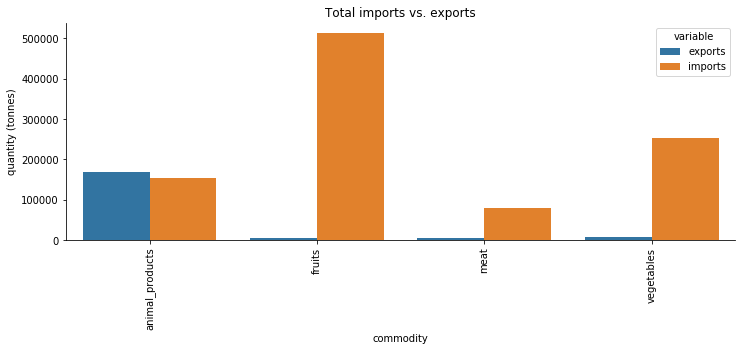

In [39]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=impex_total_metatype.index.get_level_values("type"),
    y=impex_total_metatype.values / 1000,  # kg --> tonnes
    hue=impex_total_metatype.index.get_level_values("variable"),
)

ax.set(
    title="Total imports vs. exports", xlabel="commodity", ylabel="quantity (tonnes)"
)
plt.xticks(rotation=90)
sns.despine();

As you can see, Switzerland imports many more fruits, vegetables and meat than the country exports. However, this is only part of the broader picture since domestic production is another important consideration.

Let's now load the data on domestic production from FAO:

In [80]:
production = load_fao()
production.head()

variable,production
subtype,
agave_fibres_nes,0.0
almonds_with_shell,0.0
anise_badian_fennel_coriander,0.0
apples,225622000.0
apricots,9420000.0


Next we perform an outer join of `impex_total` and `production` to create a meta-dataframe with all total macroeconomic indicators for each commodity subtype:

In [76]:
suisse = impex_total.droplevel("type").join(production, how="outer")
suisse

variable,exports,imports,production
subtype,,,
agave_fibres_nes,NaN,NaN,0.0
almonds_with_shell,NaN,NaN,0.0
anise_badian_fennel_coriander,NaN,NaN,0.0
apples,3027636.0,12116858.0,225622000.0
apricots,7492.0,11934233.0,9420000.0
...,...,...,...
wheat,NaN,NaN,530552000.0
whey,77624196.0,8145149.0,NaN
yams,0.0,152811.0,0.0


We have three possibilities for each commodity
1. Neither production or import/export values are given or they all sum up to 0
2. Either only production values are given or only import/export values are given
3. Production, import and export values are all given

Commodities fulfilling the first condition will be removed. Commodities fulfilling the second or third condition will be kept.

In [77]:
# Remove subtypes for which all given quantities sum up to 0
subtypes_no_info = suisse.index[suisse.sum(axis=1) == 0]
suisse.drop(subtypes_no_info, inplace=True)

Next, we shall add a column for production minus exports, which will serve as our estimate for *domestically produced **and** consumed* quantity (given the assumption that no food goes to waste):

$domestically\ produced\ and\ consumed \approx production - exports$

In [82]:
suisse["production_minus_exports"] = suisse.production - suisse.exports
suisse

variable,exports,imports,production,production_minus_exports
subtype,,,,
apples,3027636.0,12116858.0,225622000.0,222594364.0
apricots,7492.0,11934233.0,9420000.0,9412508.0
artichokes,658.0,1331845.0,0.0,-658.0
asparagus,3960.0,9096875.0,722000.0,718040.0
avocados,45994.0,14697330.0,0.0,-45994.0
...,...,...,...,...
wheat,NaN,NaN,530552000.0,NaN
whey,77624196.0,8145149.0,NaN,NaN
yams,0.0,152811.0,0.0,0.0


***

After finishing what is listed in the cell above, we can go further into animal feed.....

One interesting aspect of meat and non-meat animal product production, which is not relevant to the other food groups, is that animal feed may be sourced from a different location than where the meat/animal product is produced. This implicates the sourcing of animal feed as a very important factor for the carbon intensity of these foods. For example, if Switzerland produced most of its meat domestically, but it imported all of its feed, the carbon intensity of its meat would be much higher than if the feed were grown domestically. Thus, both aspects of the final food product must be examined.

Next step will be to examine Swiss production, imports, and exports of *animal feed* (coming up in the next milestone!)

## Emissions


Now that we have calculated Switzerland's production and consumption, we want to have a look at how this translates in terms of equivalent CO$_2$ production. To do this, we could look at Swiss-specific values for the greenhouse gas production for different food types, however data from other countries is very sparse and reliable data for many food types is only available for certain countries. Later in the analysis, we want to compare Swiss production emissions with Swiss import emissions, therefore for consistency we need to either have data available for all (or most) countries for a given product, or use global averages. Comprehensive data is available on meat and cereal production emissions worldwide, however fruit and vegetable figures are much harder to obtain and only a limited number of studies have been carried out. These studies have been accumulated in a systematic review (https://www.sciencedirect.com/science/article/pii/S0959652616303584) and these values have been used to calculate averages for a number of different kinds of produce. To ensure our results are consistent, we will use this generalisation of global average values to estimate the domestic Swiss emissions for fruit and vegetables.

<!---
Other thought: I've currently created a dictionary to map the different fruit/veg to the impex categories. Was just thinking, this could be a potential spot to use machine learning, although admittedly not a very useful one...
--->

In [ ]:
emissions = load_emissions()
emissions.head()

The food names in the above dataframe need to be mapped to the format of the production, imports and exports dataframe above. Taking an example dataframe containing consumption within Switzerland of Swiss produced products (Domestic Consumption), consumption of imported products (Imported Consumption) and Total Consumption (in thousand tonnes per year), we can use the above values to estimate the emissions resulting from the production of food consumed in Switzerland.

In [ ]:
pretend = {"Product":["Onion","Beetroot"], "Domestic Consumption":[1000,2000], "Imported Consumption":[2000,4000], "Total Consumption":[3000,6000]}
domestic = pd.DataFrame.from_dict(pretend)

So assuming that domestic transport is negligible, we can estimate the equivalent CO$_2$ emissions for each product type, using the global average values.

In [ ]:
# TODO update this code to work with merged dataframe above + include all categories
domestic = estimate_emissions(domestic, emissions)

In [ ]:
domestic

The final column of the above table shows the total CO$_2$ equivalent that would be produced if everything that was consumed in Switzerland was domestically produced, i.e. no transport emissions were considered and Swiss-specific CO$_2$ emissions were used for meat and cereal production. Evidently, it is not possible to produce everything that a current consumer buys locally, so in the following analysis we will consider the effect that these imported products and 'food miles' have on the CO$_2$ emissions resulting from Swiss consumption. 

The following will describe initial observations we have made regarding the transport of food, global carbon emissions intensities, and how we plan to use this information to estimate the impact consumption of different foods in Switzerland has and how a Swiss consumer can minimise their environmental impact in their food choices.

## Further Analysis

'Food miles', or the distance that food has to travel to arrive on your plate, clearly have an impact on the carbon emissions of the products we consume. Let's look at how much of the food, beverages, and tobacco that Switzerland imports comes from its nearest neighboring countries. The farther a country is, the more carbon emissions it would cost to import that food.

In [ ]:
percentage = glimpse()
print(str(round(percentage)) + "% of Switzerland's total imports come from countries within a 1000km radius.")

So we can see that a lot of Switzerland's imports come from nearby countries. We will continue in this vein and look at the origins of each product individually to see the impact these food miles/varying production methods have on their carbon footprint. One thing we will consider is the transport methods, clearly the impact of these food miles differs greatly depending on whether the food is transported by plane or ship...

In [ ]:
from IPython.display import Image
Image(url = "https://icmattermost.epfl.ch/files/5zr1jyriupfsfgmr4dtg155ssw/public?h=_GPk0xYK1I16gWsY3GuIsrFC5bTb3Ioh4_W3h3oYDs8", width=400,height=300)

Transport methods for different commodoties in the USA are described in detail in the paper *Food-Miles and the Relative Climate Impacts of Food Choices in the United States* (Weber and Matthews, 2008). These values, or similar data for other countries worldwide could be used to estimate the transport means for different products and thus the impact this transport has on emissions for each product. Perishable products more frequently have to be transported by air, and therefore have a significantly larger carbon footprint.